# Single Charger Optimizer


In [6]:
import optimizer_charger_V1 as optimizer # optimizer.py file

# import analysis # visualization 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import os 
import sys 
import optimizer_station_V2 as opt
import warnings
warnings.filterwarnings("ignore")

plt.style.use(['science','ieee','high-vis'])
plt.rcParams['font.size'] = 14
w = 7/1.2
h = 3/1.5

high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('axes', labelsize=14)

In [3]:
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################


## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


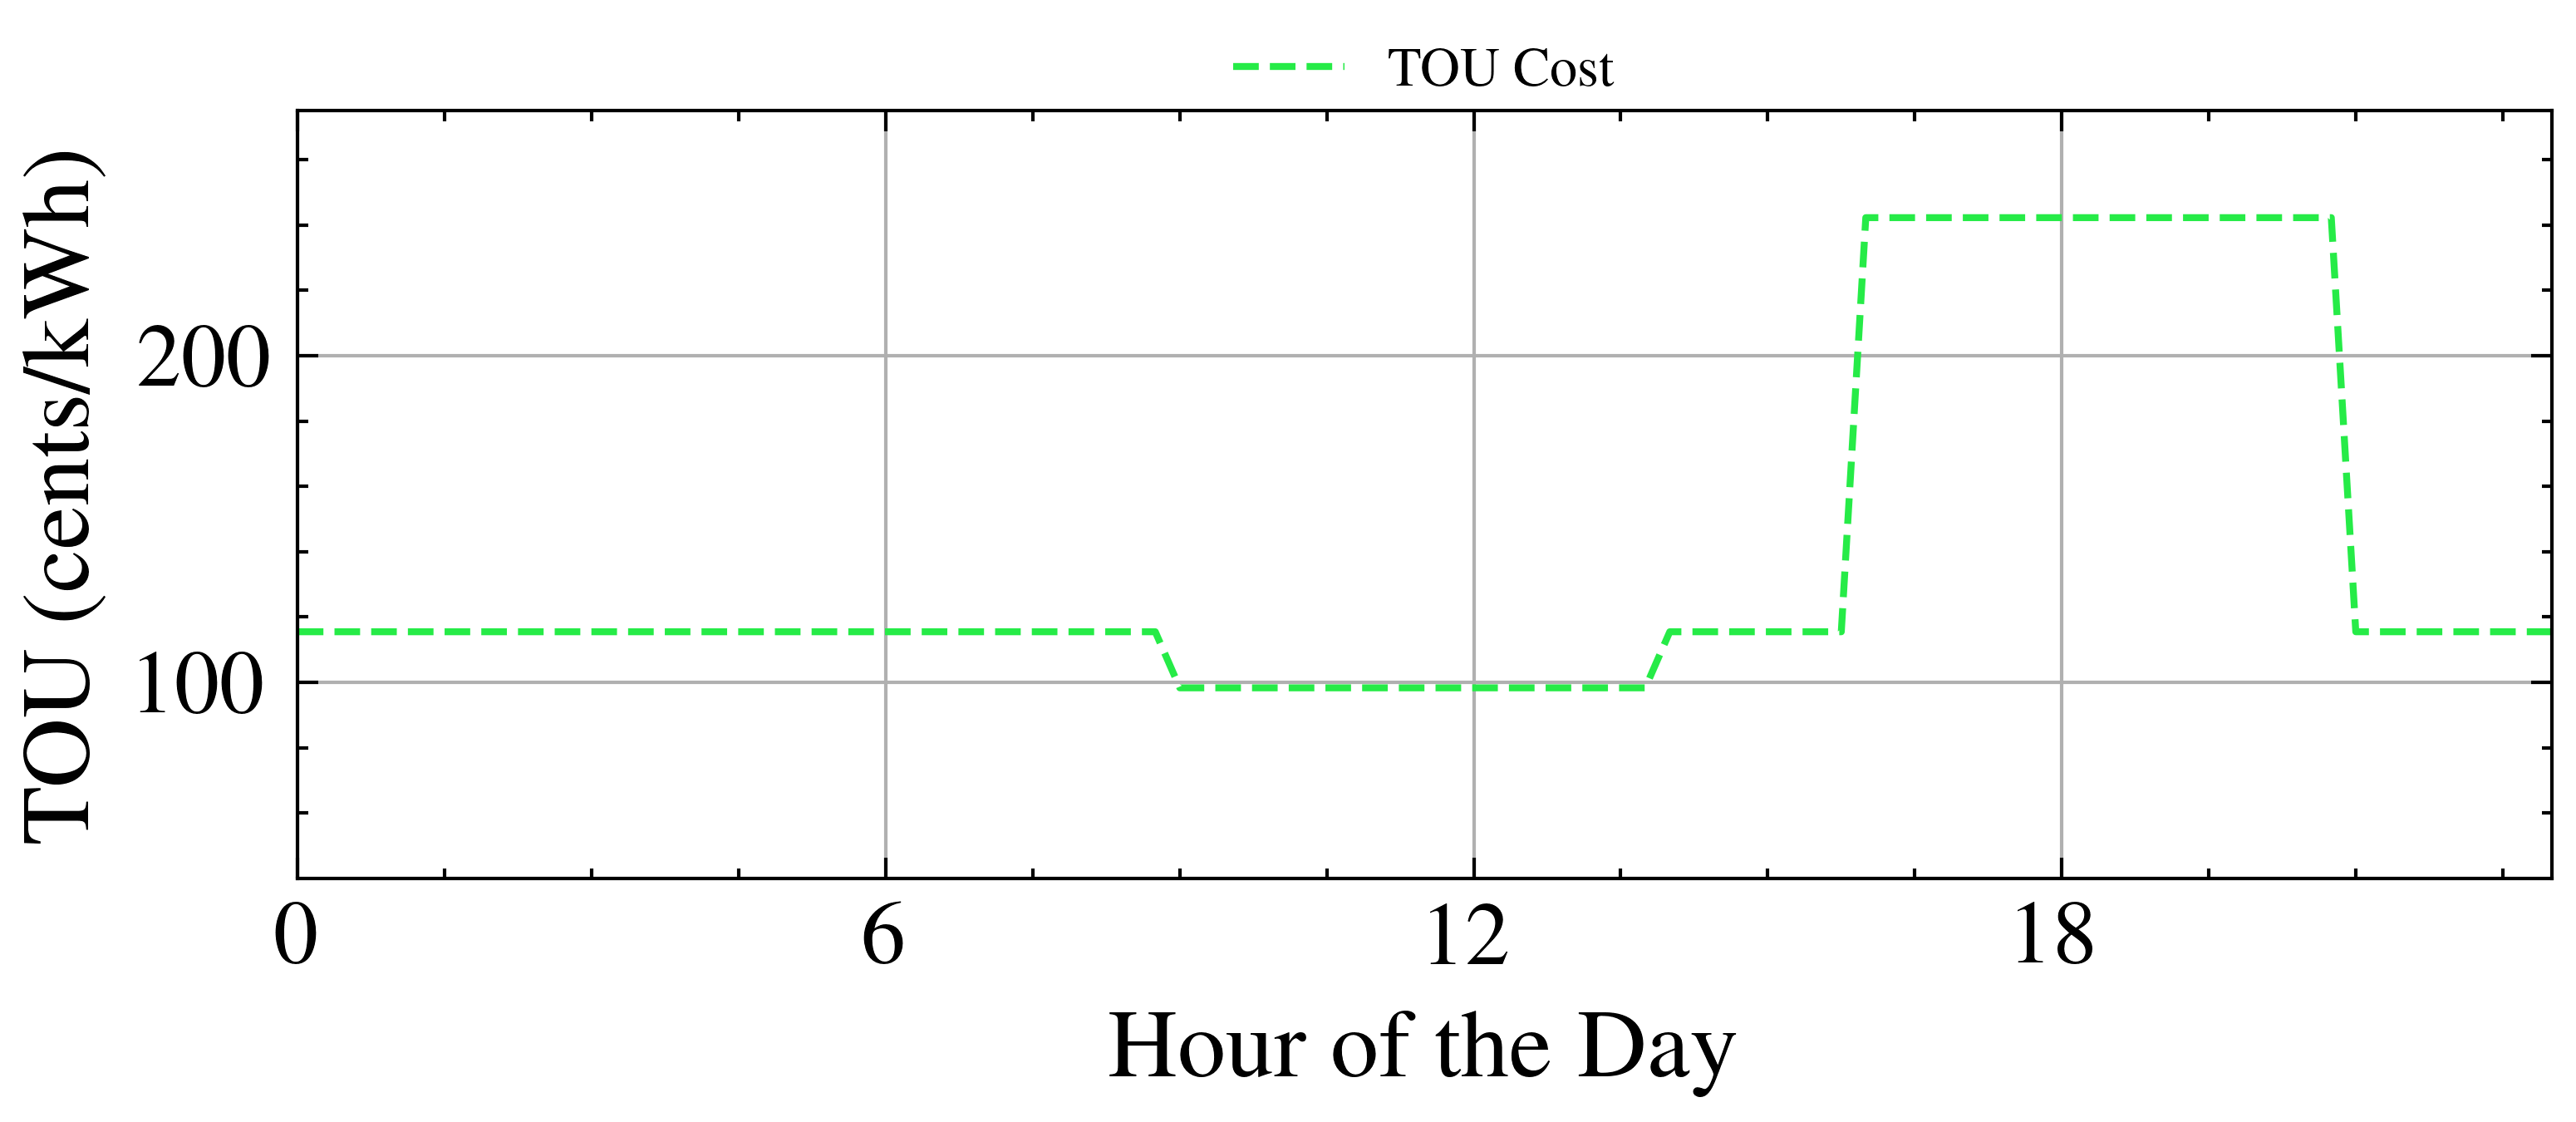

In [4]:
high_TOU = TOU_tariff * 6.6
tou = pd.DataFrame(high_TOU).reset_index(drop=False)
tou['index'] = tou['index'] / 4
# Plot initial guess vs optimization result
fig, ax = plt.subplots(1, 1, figsize=(w, h))

# Existing plot
ax.plot(np.arange(0, 24, 0.25), tou[0], label='TOU Cost', ms=0, marker='X',
        linestyle="--", color=high_vis_map[2])

# Set specific x-ticks
ax.set_xticks([0, 6, 12, 18])

# Set plot properties
ax.set_ylim(40, 275)
ax.set_xlim(0, 23)
ax.grid()
# ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")

ax.set_ylabel("TOU (cents/kWh)")

ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=6, fontsize=8)

plt.show()


In [7]:
print("Start of the Block Coordinaate Descent Algorithm: [20,30,1,1]")
par = optimizer .Parameters(z0 = np.array([20,30,1,1]).reshape(4,1),   #due to local optimality, we can try multiple starts
                            Ts = delta_t,
                            eff = 1.0 ,
                            soft_v_eta = 1e-4,
                            opt_eps = 0.0001,
                            TOU = TOU_tariff) 

###### Define users problem ######

# we receive signals as hours from the app
arrival_hour = 7.25
duration_hour = 10
e_need = 15

event = {
        "time" : int(arrival_hour / delta_t),  # INTERVAL 
        "e_need": e_need, # FLOAT 
        "duration" :int(duration_hour / delta_t), # the slider allows 15 min increments INT
        "station_pow_max"   : 6.6, 
        "user_power_rate":100
        }


prb = optimizer .Problem(par = par, event = event)

opt = optimizer .Optimization(par, prb)

res = opt .run_opt()

reg_centsPerHr, sch_centsPerHr = res["tariff_asap"], res['tariff_flex']
print("REG {} cents/kWh: , SCH {} cents/kWh:".format(np.round(reg_centsPerHr,2), 
                                                 np.round(sch_centsPerHr,2)))
print("SCH Powers:",np.round(res['flex_powers']))

Start of the Block Coordinaate Descent Algorithm: [20,30,1,1]
REG 30.48 cents/kWh: , SCH 23.56 cents/kWh:
SCH Powers: [ 0.  0.  0.  0.  0.  0.  0.  5.  4.  4.  4.  4.  3.  3.  3.  3.  3.  2.
  2.  2.  2.  2.  2.  2.  2.  3.  4.  0.  0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0.  0.]


In [8]:
powers = pd.DataFrame(index=np.arange(int(arrival_hour / delta_t),int(arrival_hour / delta_t)+int(duration_hour / delta_t),1),
             data=np.round(res['flex_powers'])).reset_index(drop=False)
powers['index'] = powers['index']/4

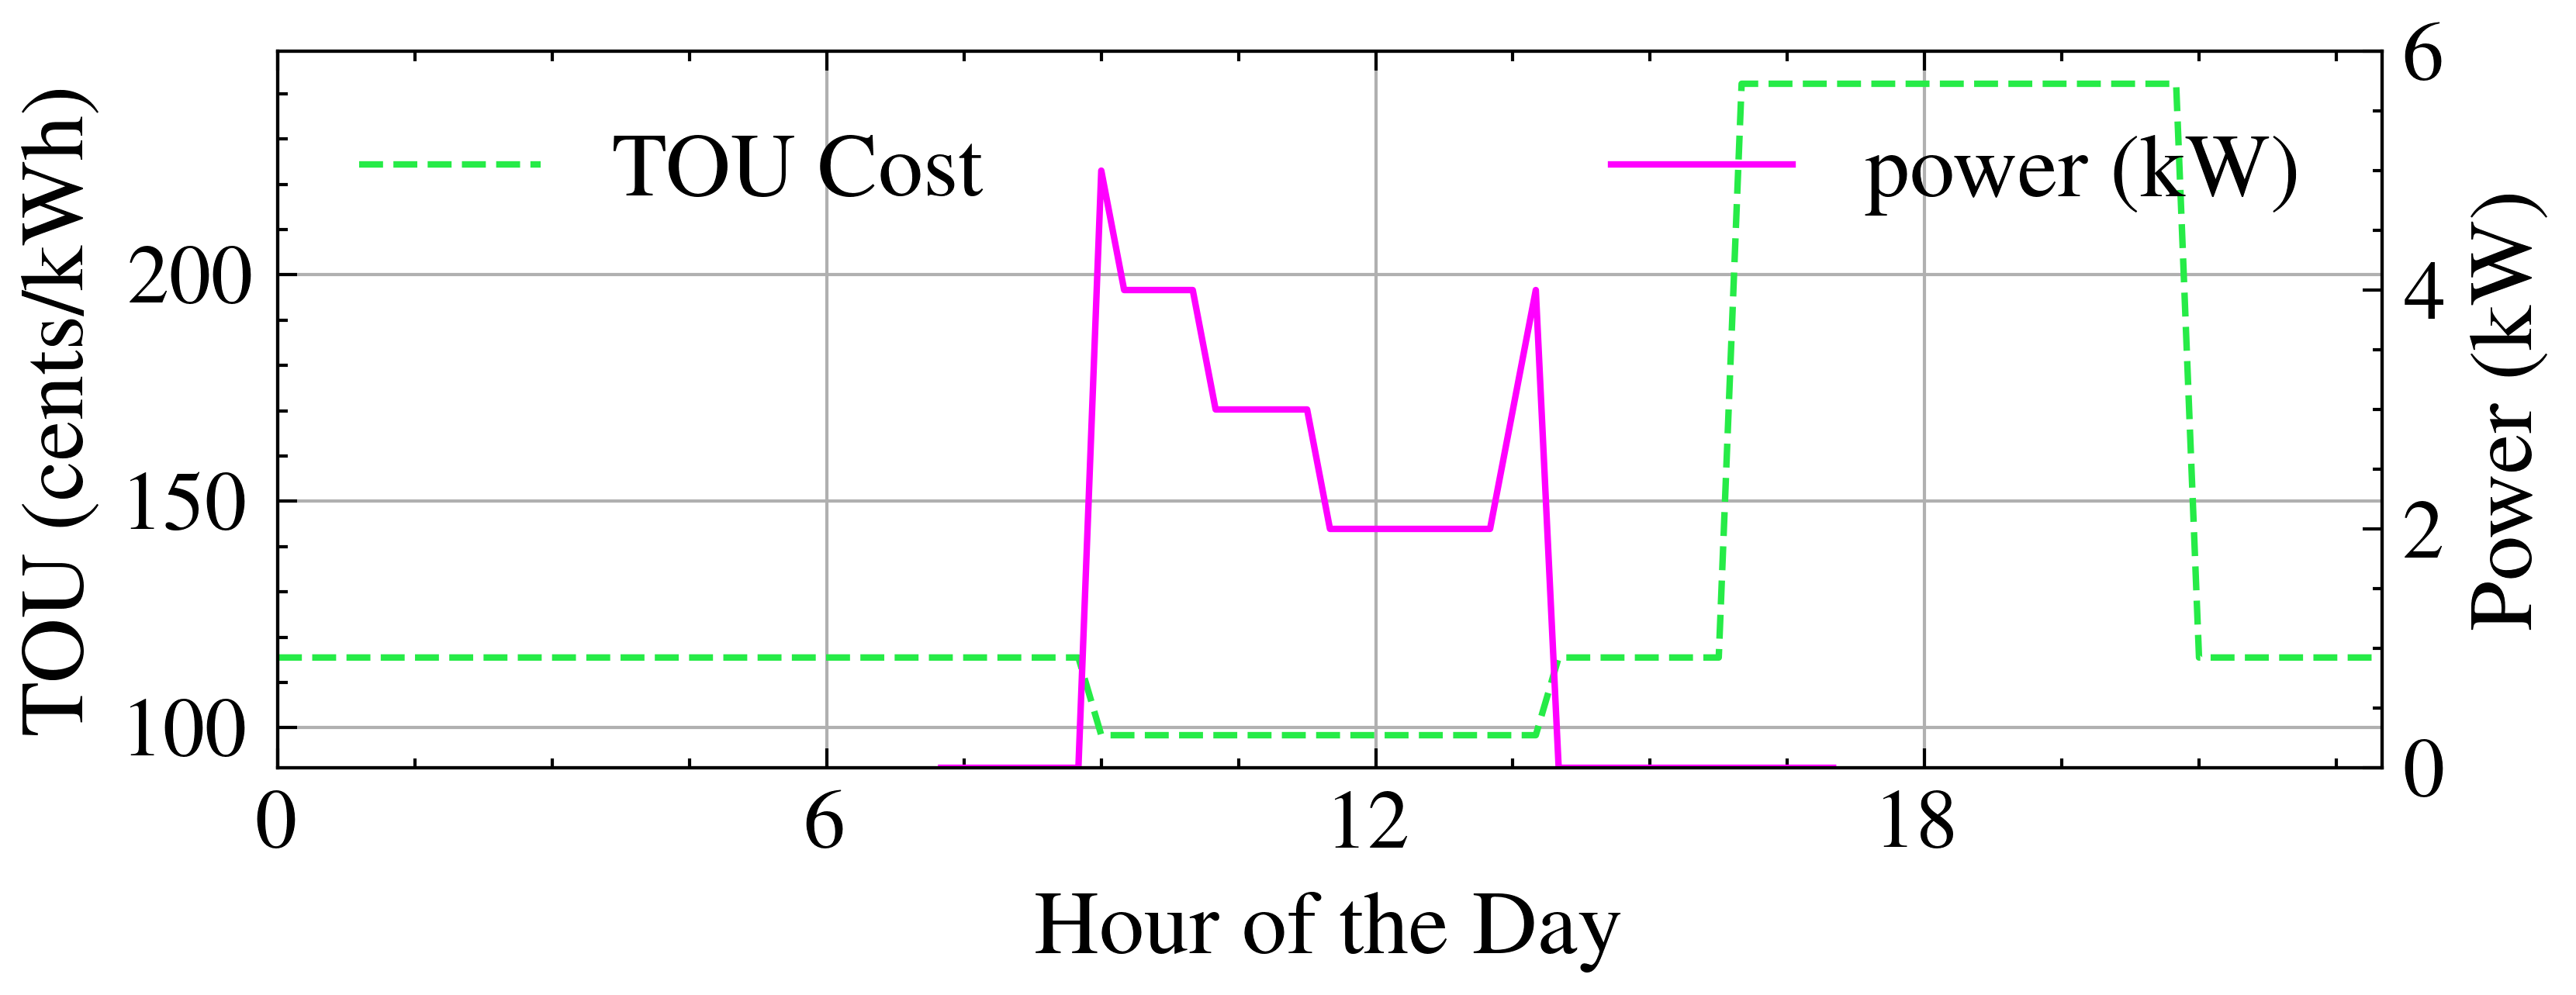

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(w, h))

# Existing plot
ax.plot(np.arange(0, 24, 0.25), tou[0], label='TOU Cost', ms=0, marker='X',
        linestyle="--", color=high_vis_map[2])

# Existing plot
ax2=ax.twinx()
ax2.plot(powers['index'], powers[0], label='power (kW)', ms=0, marker='X',
        linestyle="-", color='magenta')

# Set specific x-ticks
ax.set_xticks([0, 6, 12, 18])

# Set plot properties
# ax.set_ylim(40, 275)
ax2.set_ylim(0, 6)
ax.set_xlim(0, 23)
ax.grid()
# ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")

ax.set_ylabel("TOU (cents/kWh)")
ax2.set_ylabel("Power (kW)")
ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=6, fontsize=8)
ax.legend()
ax2.legend()
plt.show()


# Station Level Optimizer

Main inputs:
- stateRecord: State Record
- expectedDemand: User Inputs 


In [3]:
### RUN FROM THIS LINE IF GET AN ERROR!! 

In [12]:
import pandas as pd
from deployment_utils import emptyStateRecord, arrHourList, data_format_convertion, unixTime, TOU_15min, convertOutput, NumpyEncoder,convert_floats_to_decimals, currentTime15min, table_to_optimizedStates, stringify_keys, table_to_stateRecord
import optimizer_station_V2 as opt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import os 
import sys 

In [13]:
#### How we create a state record, what are the parameters

# Empty state record: initial state, before no vehicle arrives 
timestamp = pd.Timestamp(year= 2023, month= 12,day=5, hour=8,minute=15 )
stateRecords = emptyStateRecord(timestamp)
print(stateRecords)

[{'monthlyPeak': 0, 'timestamp': 1701764100, 'sessions': []}]


In [14]:
##### New user info
delta_t= 0.25
hour=9
e_need = 10
duration_hour = 10

event = {
    "time": int(hour / delta_t), # Hour or Arrival_hour?
    "e_need": e_need,
    "duration": int(duration_hour / delta_t),
    "station_pow_max": 6.6,
#     "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
    "user_power_rate": 6.6,
    "limit_reg_with_sch": False,
    "limit_sch_with_constant": False,
    "sch_limit": 0,
    "historical_peak": 0
}

import warnings
warnings.filterwarnings("ignore")

In [15]:
20 * 6.6

132.0

In [16]:
### Run no vehicles case 
print("Peak: ",stateRecords[0]['monthlyPeak'])
# Converting from the stateRecord to station info
# Getting rid of the timestamp index, converting to kW
sessionRecord = data_format_convertion(stateRecords, hour, delta_t)

par = opt.Parameters(z0 = np.array([20, 35, 1, 1]).reshape(4, 1),
             Ts = delta_t,
             eff = 1.0,
             soft_v_eta = 1e-4,
             opt_eps = 0.0001,
             TOU = TOU_15min(),
             demand_charge_cost=1800) ## cents/ kW 

prb = opt.Problem(par, sessionRecord, hour, event=event)
# try: 
obj = opt.Optimization_station(par, prb,hour)
station_info, res_bcd = obj.run_opt(solution_algorithm="BCD")
reg_centsPerHr, sch_centsPerHr = res_bcd["reg_centsPerHr"], res_bcd['sch_centsPerHr']
print("REG {} cents/kWh: , SCH {} cents/kWh:".format(np.round(reg_centsPerHr / 6.6,2), 
                                                 np.round(sch_centsPerHr/6.6,2)))

station_info, res = obj.run_opt(solution_algorithm="grid_search")

# reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']
# print("REG {} cents/kWh: , SCH {} cents/kWh:".format(np.round(reg_centsPerHr / 6.6,2), 
#                                                  np.round(sch_centsPerHr/6.6,2)))
# np.round(res['sch_powers'])

Peak:  0





[-2750.74967321]
REG 45.0 cents/kWh: , SCH 29.31 cents/kWh:

DC_SCH: [0.99999999] DC_REG: [6.6]























In [19]:
from scipy.special import softmax
zk =  par.z0
zk[0] = 33
zk[1] = 45
obj.constr_J(res['sch_powers'], zk, softmax(prb.THETA @ zk).reshape(3,1), 2, 6.6)[1].sum()

3695.3866930122354

In [20]:
# from scipy.special import softmax
zk =  par.z0
zk[0] = 45
zk[1] = 45
obj.constr_J(res['sch_powers'], zk, softmax(prb.THETA @ zk).reshape(3,1), 2.35, 6.6)[1].sum()

5032.53244219665

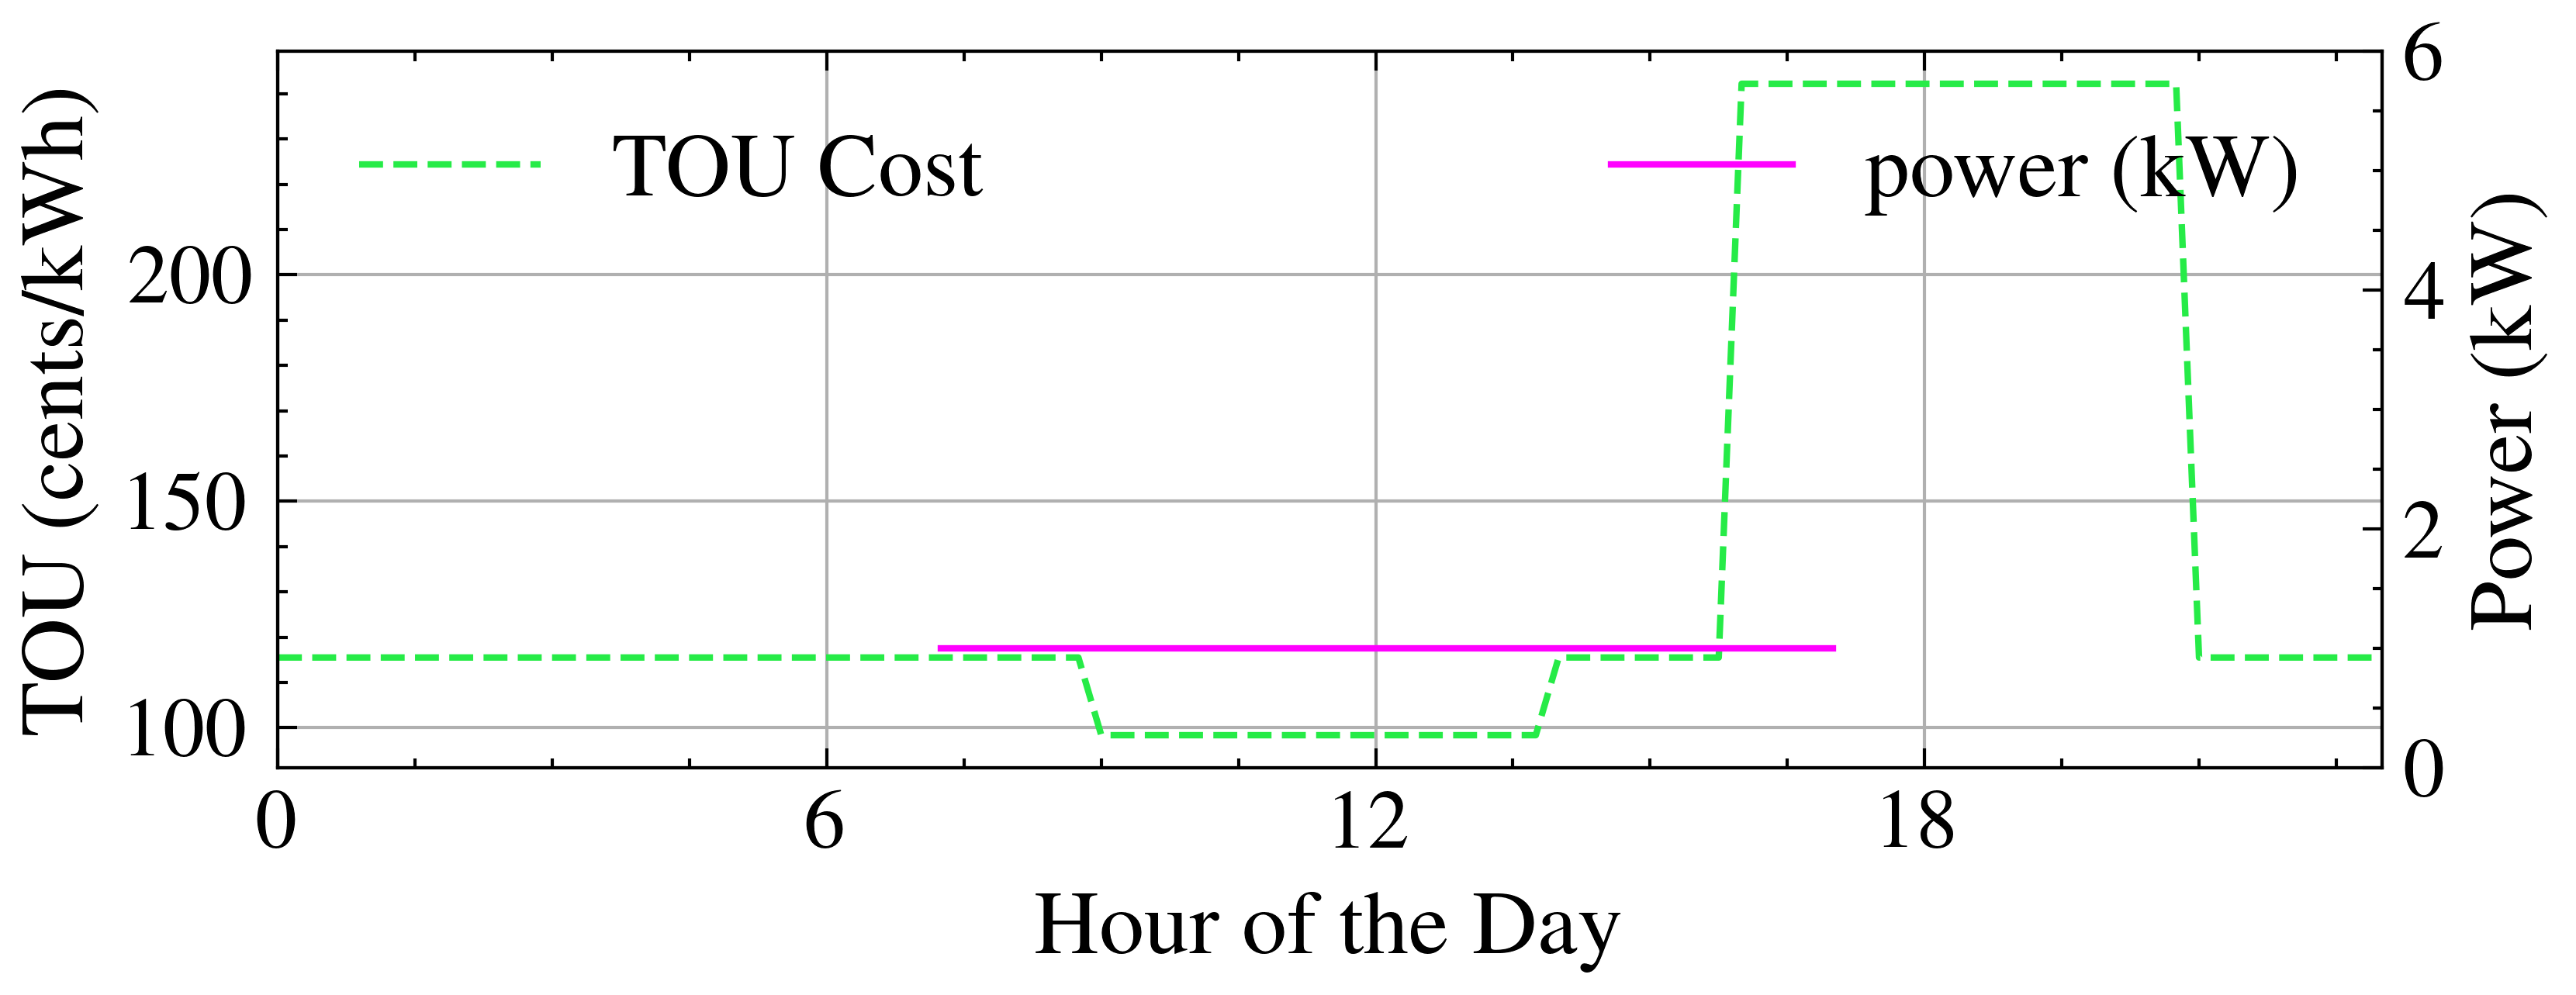

In [21]:
powers = pd.DataFrame(index=np.arange(int(arrival_hour / delta_t),int(arrival_hour / delta_t)+int(duration_hour / delta_t),1),
             data=np.round(res['sch_powers'])).reset_index(drop=False)
powers['index'] = powers['index']/4

fig, ax = plt.subplots(1, 1, figsize=(w, h))

# Existing plot
ax.plot(np.arange(0, 24, 0.25), tou[0], label='TOU Cost', ms=0, marker='X',
        linestyle="--", color=high_vis_map[2])

# Existing plot
ax2=ax.twinx()
ax2.plot(powers['index'], powers[0], label='power (kW)', ms=0, marker='X',
        linestyle="-", color='magenta')

# Set specific x-ticks
ax.set_xticks([0, 6, 12, 18])
ax2.set_ylim(0, 6)
# Set plot properties
# ax.set_ylim(40, 275)
ax.set_xlim(0, 23)
ax.grid()
# ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")

ax.set_ylabel("TOU (cents/kWh)")
ax2.set_ylabel("Power (kW)")
ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=6, fontsize=8)
ax.legend()
ax2.legend()
plt.show()


In [135]:
31.96*6.6, 21.68*6.6

(210.936, 143.088)

In [109]:
##### Another user info, higher peak this time 
hour = 6.5
e_need = 10
duration_hour = 6.7

event = {
    "time": int(hour / delta_t), # Hour or Arrival_hour?
    "e_need": e_need,
    "duration": int(duration_hour / delta_t),
    "station_pow_max": 6.6,
#     "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
    "user_power_rate": 6.6,
    "limit_reg_with_sch": False,
    "limit_sch_with_constant": False,
    "sch_limit": 0,
    "historical_peak": 2.5
}

# Run no vehicles case 
# Converting from the stateRecord to station info
# Getting rid of the timestamp index, converting to kW
sessionRecord = data_format_convertion(stateRecords, hour, delta_t)

par = opt.Parameters(z0 = np.array([20, 30, 1, 1]).reshape(4, 1),
             Ts = delta_t,
             eff = 1.0,
             soft_v_eta = 1e-4,
             opt_eps = 0.0001,
             TOU = TOU_15min(),
             demand_charge_cost=1800/30) ## cents/ hr 

prb = opt.Problem(par=par, event=event)
# try: 
obj = opt.Optimization_station(par, prb, sessionRecord, hour)
station_info, res = obj.run_opt()

reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']
print("REG {} cents/kWh: , SCH {} cents/kWh:".format(np.round(reg_centsPerHr / 6.6,2), 
                                                 np.round(sch_centsPerHr/6.6,2)))
# np.round(res['sch_powers'],2)

Set parameter Username
GUROBI not installed
REG 31.41 cents/kWh: , SCH 21.07 cents/kWh:


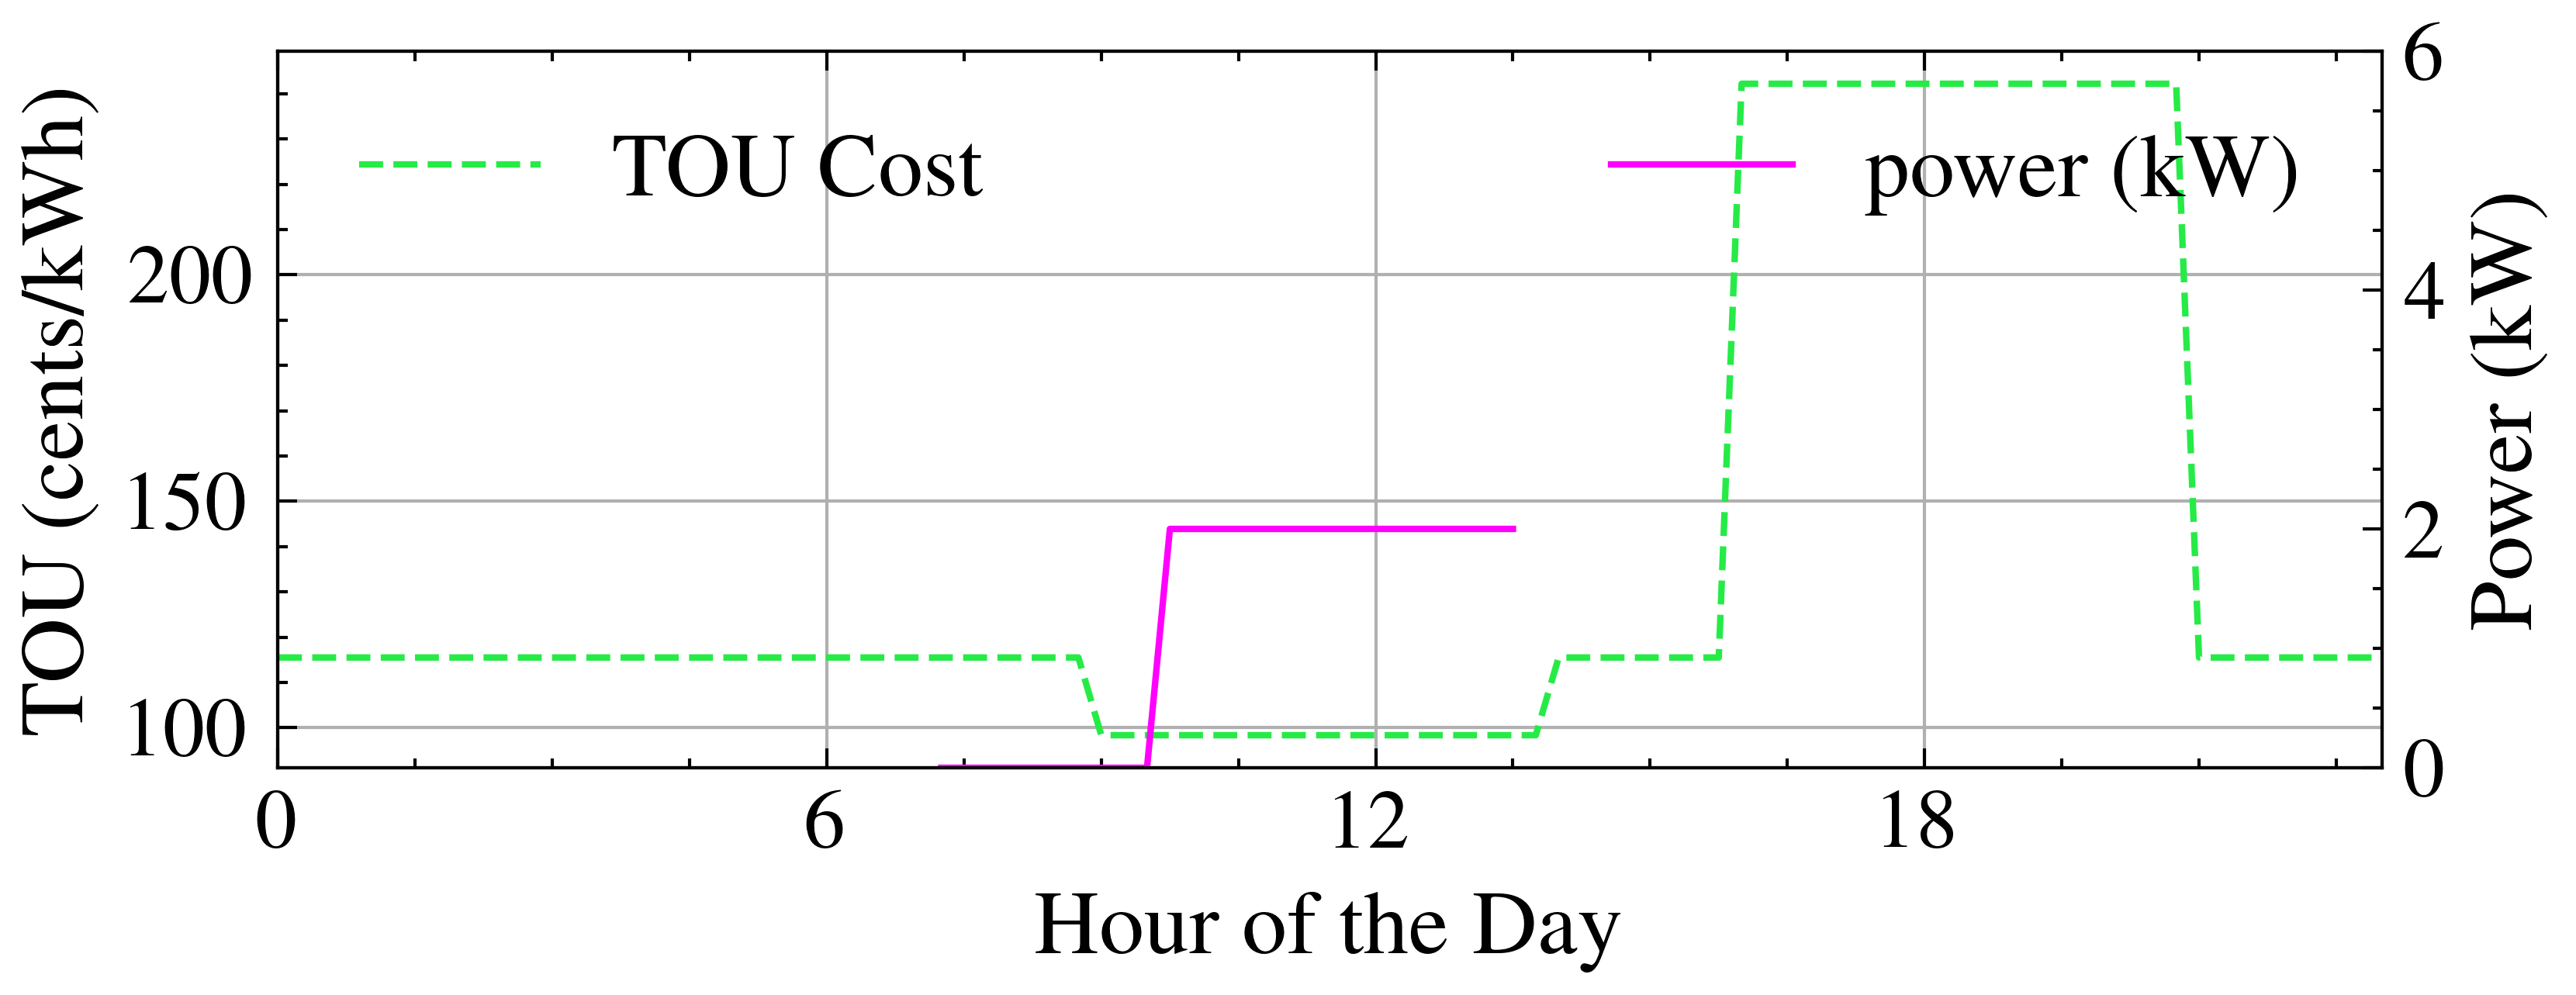

In [110]:
powers = pd.DataFrame(index=np.arange(int(arrival_hour / delta_t),int(arrival_hour / delta_t)+int(duration_hour / delta_t),1),
             data=np.round(res['sch_powers'])).reset_index(drop=False)
powers['index'] = powers['index']/4

fig, ax = plt.subplots(1, 1, figsize=(w, h))

# Existing plot
ax.plot(np.arange(0, 24, 0.25), tou[0], label='TOU Cost', ms=0, marker='X',
        linestyle="--", color=high_vis_map[2])

# Existing plot
ax2=ax.twinx()
ax2.plot(powers['index'], powers[0], label='power (kW)', ms=0, marker='X',
        linestyle="-", color='magenta')

# Set specific x-ticks
ax.set_xticks([0, 6, 12, 18])

# Set plot properties
ax2.set_ylim(0, 6)
ax.set_xlim(0, 23)
ax.grid()
# ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")

ax.set_ylabel("TOU (cents/kWh)")
ax2.set_ylabel("Power (kW)")
ax.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=6, fontsize=8)
ax.legend()
ax2.legend()
plt.show()


In [111]:
from deployment_app import queryLastStateRecord
stateRecords = queryLastStateRecord() # in case thats empty 



stateRecords = [{'timestamp': 1701702900,
  'monthlyPeak': 19.8,
  'sessions': [{'dcosId': 6512,
    'choice': 'SCH',
    'powerRate': 'HIGH',
    'energyNeeded': 35548.0,
    'optPower': [[1701684000.0, 6600.0],
     [1701684900.0, 6600.0],
     [1701685800.0, 6600.0],
     [1701686700.0, 6600.0],
     [1701687600.0, 6600.0],
     [1701688500.0, 6600.0],
     [1701689400.0, 6600.0],
     [1701690300.0, 6600.0],
     [1701691200.0, 6600.0],
     [1701692100.0, 6600.0],
     [1701693000.0, 6600.0],
     [1701693900.0, 6600.0],
     [1701694800.0, 6600.0],
     [1701695700.0, 6600.0],
     [1701696600.0, 6600.0],
     [1701697500.0, 6600.0],
     [1701698400.0, 6600.0],
     [1701699300.0, 3593.0],
     [1701700200.0, 0.0],
     [1701701100.0, 0.0],
     [1701702000.0, 6600.0],
     [1701702900.0, 6600.0],
     [1701703800.0, 6600.0],
     [1701704700.0, 6600.0]],
    'deadline': 1701705600}]}]

In [137]:
stateRecords = queryLastStateRecord() # in case thats empty
stateRecords

[{'timestamp': 1701791029,
  'monthlyPeak': 19.8,
  'sessions': [{'dcosId': 6525,
    'choice': 'REG',
    'powerRate': 'HIGH',
    'energyNeeded': 17491.0,
    'optPower': [[1701781200.0, 6600.0],
     [1701782100.0, 6600.0],
     [1701783000.0, 6600.0],
     [1701783900.0, 6600.0],
     [1701784800.0, 6600.0],
     [1701785700.0, 6600.0],
     [1701786600.0, 6600.0],
     [1701787500.0, 6600.0],
     [1701788400.0, 6600.0],
     [1701789300.0, 6600.0],
     [1701790200.0, 3970.0]],
    'deadline': 1701791100},
   {'dcosId': 6526,
    'choice': 'REG',
    'powerRate': 'HIGH',
    'energyNeeded': 15778.0,
    'optPower': [[1701788400.0, 6600.0],
     [1701789300.0, 6600.0],
     [1701790200.0, 6600.0],
     [1701791100.0, 6600.0],
     [1701792000.0, 6600.0],
     [1701792900.0, 6600.0],
     [1701793800.0, 6600.0],
     [1701794700.0, 6600.0],
     [1701795600.0, 6600.0],
     [1701796500.0, 3712.0]],
    'deadline': 1701797400}]}]

In [113]:
##### Another user info
hour = 12.5
e_need = 6
duration_hour = 6.7

event = {
    "time": int(hour / delta_t), # Hour or Arrival_hour?
    "e_need": e_need,
    "duration": int(duration_hour / delta_t),
    "station_pow_max": 6.6,
#     "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
    "user_power_rate": 6.6,
    "limit_reg_with_sch": False,
    "limit_sch_with_constant": False,
    "sch_limit": 0,
    "historical_peak": 5
}

# Run no vehicles case 
# Converting from the stateRecord to station info
# Getting rid of the timestamp index, converting to kW
sessionRecord = data_format_convertion(stateRecords, hour, delta_t)

par = opt.Parameters(z0 = np.array([20, 30, 1, 1]).reshape(4, 1),
             Ts = delta_t,
             eff = 1.0,
             soft_v_eta = 1e-4,
             opt_eps = 0.0001,
             TOU = TOU_15min(),
             demand_charge_cost=1800) ## cents/ hr 

prb = opt.Problem(par=par, event=event)
# try: 
obj = opt.Optimization_station(par, prb, sessionRecord, hour)
station_info, res = obj.run_opt()

reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']
print("REG {} cents/kWh: , SCH {} cents/kWh:".format(np.round(reg_centsPerHr / 6.6,2), 
                                                 np.round(sch_centsPerHr/6.6,2)))
# np.round(res['sch_powers'])

Set parameter Username
GUROBI not installed
REG 32.05 cents/kWh: , SCH 21.81 cents/kWh:


In [114]:
optTime = pd.Timestamp(2023,12,5,8)
output = convertOutput(stateRecords, station_info, res, hour, "SCH", optTime)

2023-12-05 08:00:00


# Deployment Demo
- triggerOptimizationAfterNewConnection(engineRecord)
- triggerTimeBasedOptimization()

In [118]:
from deployment_utils import emptyStateRecord, arrHourList, data_format_convertion, unixTime, TOU_15min, convertOutput, NumpyEncoder,convert_floats_to_decimals, currentTime15min, table_to_optimizedStates, stringify_keys, table_to_stateRecord
from deployment_app import queryLastStateRecord, dropFinishedSessions,generateOptPricePower,queryExpectedDemand

In [119]:
optTime = currentTime15min() ## currentTime rounded down to 15min 
# optTime = pd.Timestamp(year=2023,month=10, day = 9 , hour = 11 , minute= 0)
optHour = optTime.hour
stateRecords = queryLastStateRecord() # List with one element #TODO: Fix this, why its a list? 
stateRecords = dropFinishedSessions(stateRecords,optTime)

stateRecords[0]['timestamp'] = unixTime(optTime)
print(stateRecords[0]['timestamp'])
expectedDemand = queryExpectedDemand()

OptimizedStates, optimizedPrices_v3  = generateOptPricePower(stateRecords, 
                                                    expectedDemand,
                                                    optTime, 
                                                    optHour,
                                                    opt_horizon=5, TOU_tariff=TOU_15min())   ##### POTENTIAL FUTURE STATES 

# postOptimizedStates(OptimizedStates)
# postOptimizedPrices_v3(optimizedPrices_v3, optTime)
# postStateRecords(stateRecords)

1701770400
opt horizon: 5
Optimizing for: 10 0
Peak:  19.8
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Use

Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI not installed
Set parameter Username
GUROBI no

GUROBI not installed
Set parameter Username
GUROBI not installed
2023-12-05 10:00:00
2023-12-05 10:00:00


In [120]:
 optimizedPrices_v3

,,estDurationHrs,estEnergykWh,userPower_kW,SCH_expected_power_W,REG_expected_power_W,sch_centsPerHr,reg_centsPerHr
arrHour,highPower,,,,,,,
0,1,1.907635,11.853500,6.6,NaN,NaN,NaN,NaN
1,1,1.907635,11.853500,6.6,NaN,NaN,NaN,NaN
10,1,6.009141,35.548370,6.6,"{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...","{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...",179.901751,209.142525
11,1,3.281801,19.018906,6.6,"{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...","{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...",163.330416,205.018645
12,1,3.615329,15.254044,6.6,"{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...","{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...",171.464050,207.375116
13,1,3.244813,17.491875,6.6,"{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...","{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...",175.477822,208.942077
14,1,2.247329,12.330600,6.6,"{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...","{""timestamp"": 1701770400, ""monthlyPeak"": 19.8,...",180.237749,213.007453
15,1,2.673359,15.778222,6.6,NaN,NaN,NaN,NaN
16,1,2.879231,16.111375,6.6,NaN,NaN,NaN,NaN
